<a href="https://colab.research.google.com/github/count-im/test/blob/main/test/NLP/NLP01/Papago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파파고1(스페인영어)

In [1]:
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


데이터 전처리

In [4]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.10.0+cu128


In [9]:
dataset_dir = os.path.expanduser("work/s2s_translation/datasets")
os.makedirs(dataset_dir, exist_ok=True)

zip_path = os.path.join(dataset_dir, "spa-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "spa-eng")
if not os.path.exists(data_folder):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "spa.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

데이터셋 디렉토리: ['spa-eng', 'spa-eng.zip']


In [10]:
df = pd.read_csv(path_to_file, sep = "\t", names = ["eng", "spa"])
df.head()

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


데이터 전처리: 정제하기

In [12]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

print("파파고!")

파파고!


In [13]:
#df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["spa"] = df["spa"].apply(lambda x: preprocess_sentence(x))

df.head()

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .


데이터 전처리: 토큰화

In [14]:
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["spa"].to_csv("spa_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, spa_corpus.txt")

파일 저장 완료: eng_corpus.txt, spa_corpus.txt


In [15]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "spa_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

In [16]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [17]:
df

,eng,spa
0,go .,ve .
1,go .,vete .
2,go .,vaya .
3,go .,v yase .
4,hi .,hola .
...,...,...
118959,there are four main causes of alcohol related ...,hay cuatro causas principales de muertes relac...
118960,there are mothers and fathers who will lie awa...,hay madres y padres que se quedan despiertos d...
118961,a carbon footprint is the amount of carbon dio...,una huella de carbono es la cantidad de contam...
118962,since there are usually multiple websites on a...,como suele haber varias p ginas web sobre cual...


In [18]:
eng_sample = df["eng"][10000]
spa_sample = df["spa"][10000]
print(eng_sample)
print(spa_sample)

do you like fish ?
te gusta el pescado ?


In [19]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1, 28, 10, 52, 401, 15, 2]

In [20]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'do you like fish ?'

In [22]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['spa']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [23]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 30 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 70% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 30]) torch.Size([64, 30]) torch.Size([64, 30])


모델 설계

In [25]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [27]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [28]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

In [30]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [31]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


훈련하기

Optimizer & Loss

In [32]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("파파고!")

파파고!


train_step

In [35]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)
        optimizer.zero_grad()

        outputs,_ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

print("파파고!")


파파고!


훈련 시작하기

In [66]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 980/980 [03:36<00:00,  4.54it/s, loss=1.92]


Epoch 1/10, Train Loss: 2.3450


Epoch 2:  77%|███████▋  | 751/980 [02:42<00:49,  4.62it/s, loss=1.66]


KeyboardInterrupt: 

실습하기

In [37]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

        outputs, _ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

print("파파고!")

파파고!


In [ ]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 1488/1488 [04:59<00:00,  4.97it/s, loss=2.44]


Epoch 1/20, Train Loss: 3.1705, Validation Loss: 3.3417


Epoch 2: 100%|██████████| 1488/1488 [04:58<00:00,  4.98it/s, loss=4.68]


Epoch 2/20, Train Loss: 3.1412, Validation Loss: 3.3525


Epoch 3: 100%|██████████| 1488/1488 [04:53<00:00,  5.06it/s, loss=3.57]


Epoch 3/20, Train Loss: 3.1207, Validation Loss: 3.3435


Epoch 4: 100%|██████████| 1488/1488 [04:57<00:00,  4.99it/s, loss=3.39]


Epoch 4/20, Train Loss: 3.0968, Validation Loss: 3.3094


Epoch 5: 100%|██████████| 1488/1488 [04:55<00:00,  5.04it/s, loss=3.22]


Epoch 5/20, Train Loss: 3.0743, Validation Loss: 3.3843


Epoch 6: 100%|██████████| 1488/1488 [04:53<00:00,  5.07it/s, loss=3.65]


Epoch 6/20, Train Loss: 3.0593, Validation Loss: 3.3168


Epoch 7: 100%|██████████| 1488/1488 [04:53<00:00,  5.07it/s, loss=3.03]


Epoch 7/20, Train Loss: 3.0406, Validation Loss: 3.3384


Epoch 8: 100%|██████████| 1488/1488 [04:54<00:00,  5.05it/s, loss=2.8]


Epoch 8/20, Train Loss: 3.0248, Validation Loss: 3.2989


Epoch 9: 100%|██████████| 1488/1488 [04:57<00:00,  5.00it/s, loss=3.5]


Epoch 9/20, Train Loss: 3.0103, Validation Loss: 3.3770


Epoch 10: 100%|██████████| 1488/1488 [04:54<00:00,  5.06it/s, loss=2.87]


Epoch 10/20, Train Loss: 2.9975, Validation Loss: 3.3139


Epoch 11: 100%|██████████| 1488/1488 [04:55<00:00,  5.04it/s, loss=3.72]


Epoch 11/20, Train Loss: 2.9848, Validation Loss: 3.3847


Epoch 12: 100%|██████████| 1488/1488 [04:58<00:00,  4.99it/s, loss=3.75]


Epoch 12/20, Train Loss: 2.9718, Validation Loss: 3.3203


Epoch 13: 100%|██████████| 1488/1488 [04:55<00:00,  5.04it/s, loss=4.34]


Epoch 13/20, Train Loss: 2.9663, Validation Loss: 3.3475


Epoch 14: 100%|██████████| 1488/1488 [04:54<00:00,  5.05it/s, loss=3.49]


Epoch 14/20, Train Loss: 2.9468, Validation Loss: 3.3250


Epoch 15: 100%|██████████| 1488/1488 [04:56<00:00,  5.03it/s, loss=3.03]


Epoch 15/20, Train Loss: 2.9364, Validation Loss: 3.3596


Epoch 16: 100%|██████████| 1488/1488 [04:58<00:00,  4.99it/s, loss=3.1]


Epoch 16/20, Train Loss: 2.9289, Validation Loss: 3.3397


Epoch 17: 100%|██████████| 1488/1488 [04:58<00:00,  4.99it/s, loss=2.89]


Epoch 17/20, Train Loss: 2.9213, Validation Loss: 3.3139


Epoch 18: 100%|██████████| 1488/1488 [04:54<00:00,  5.05it/s, loss=3.57]


Epoch 18/20, Train Loss: 2.9102, Validation Loss: 3.3207


Epoch 19: 100%|██████████| 1488/1488 [04:57<00:00,  5.01it/s, loss=3.13]


Epoch 19/20, Train Loss: 2.9033, Validation Loss: 3.3313


Epoch 20: 100%|██████████| 1488/1488 [04:53<00:00,  5.08it/s, loss=3.75]


Epoch 20/20, Train Loss: 2.8969, Validation Loss: 3.3248
CPU times: user 1h 45min 33s, sys: 30.9 s, total: 1h 46min 4s
Wall time: 1h 47min 25s


Attention Map

In [ ]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [ ]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: the most powerful man all over the world .
Predicted translation: ['el', 'la', 'res', 'hombre', 'todo', 'sobre', 'la', 'segunda', 'ca', 'brit', 'nico', '.', '']


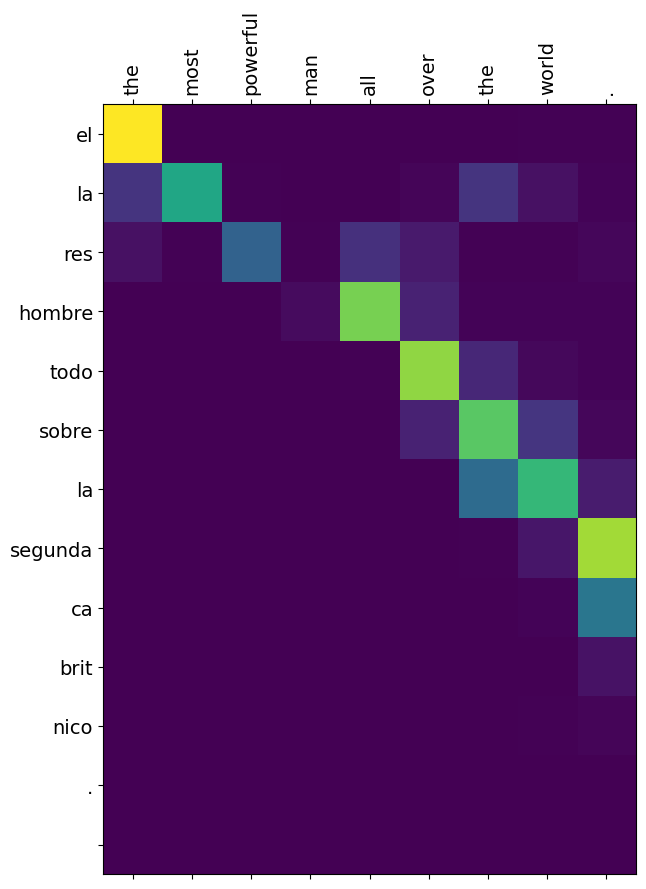

In [ ]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: may i help you ?
Predicted translation: ['pued', 'o', '.', '']


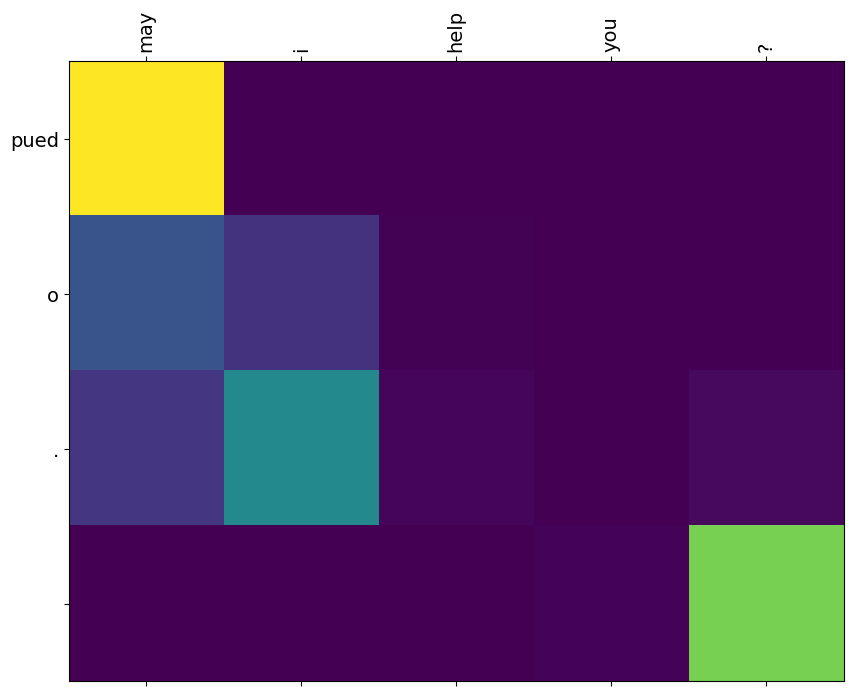

In [ ]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['puede', 's', '.', 'caf', '?', '']


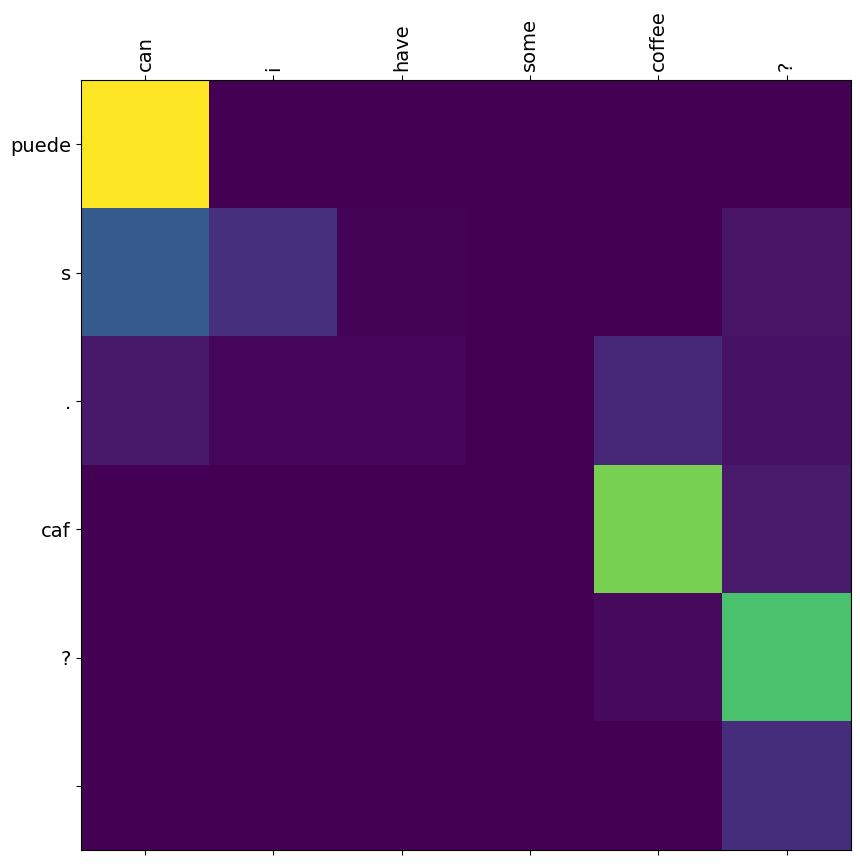

In [ ]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

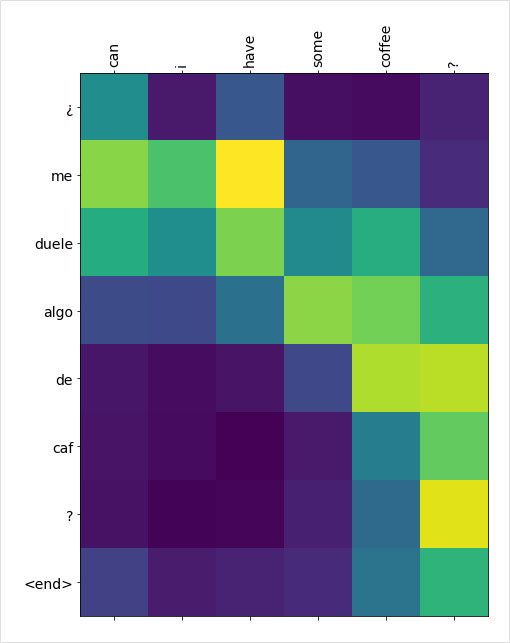

파파고2(한영)

In [70]:
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [71]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


데이터 전처리

In [72]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.10.0+cu128


In [73]:
import tarfile  # tar 압축 풀기

dataset_dir = os.path.expanduser("~/work/s2s_translation/datasets")
os.makedirs(dataset_dir, exist_ok=True)

zip_path = os.path.join(dataset_dir, "korean-english-park.train.tar.gz")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz"
    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

data_folder = os.path.join(dataset_dir, "korean-english-park.train")

if not os.path.exists(data_folder):
    print("tar.gz 압축 해제 중...")
    # 'r:gz'는 'gzip으로 압축된 파일을 읽기 모드로 열기'라는 뜻입니다.
    with tarfile.open(zip_path, 'r:gz') as tar_ref:
        tar_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(data_folder, "spa.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))

tar.gz 압축 해제 중...


/tmp/ipython-input-304/4141698584.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(dataset_dir)


압축 해제 완료!
데이터셋 디렉토리: ['korean-english-park.train.ko', 'korean-english-park.train.en', 'korean-english-park.train.tar.gz']


In [74]:

# The previous cell extracted 'korean-english-park.train.en' and 'korean-english-park.train.ko'
# into the `dataset_dir`. We need to read these two files separately.

path_to_eng_file = os.path.join(dataset_dir, "korean-english-park.train.en")
path_to_kor_file = os.path.join(dataset_dir, "korean-english-park.train.ko")

# Read the English and Korean sentences
with open(path_to_eng_file, "r", encoding="utf-8") as f:
    eng_sentences = f.readlines()
with open(path_to_kor_file, "r", encoding="utf-8") as f:
    kor_sentences = f.readlines()

# Strip newline characters and create a DataFrame
df = pd.DataFrame({'eng': [s.strip() for s in eng_sentences],
                   'kor': [s.strip() for s in kor_sentences]})
df.head()

,eng,kor
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


데이터 전처리: 정제하기

In [75]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

print("파파고!")

파파고!


In [76]:
#df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["kor"] = df["kor"].apply(lambda x: preprocess_sentence(x))

df.head()

,eng,kor
0,much of personal computing is about can you to...,?
1,so a mention a few weeks ago about a rechargea...,.
2,"like all optical mice , but it also doesn t ne...",.
3,uses gyroscopic sensors to control the cursor ...,". , , ."
4,intelligence officials have revealed a spate o...,", ."


In [77]:
# 3. 중복 데이터 완벽 제거 (한국어-영어 쌍이 완전히 똑같은 경우 제거)
df.drop_duplicates(inplace=True)

데이터 전처리: 토큰화

In [78]:
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["kor"].to_csv("kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")

파일 저장 완료: eng_corpus.txt, kor_corpus.txt


In [79]:
vocab_size = 3000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "kor_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

In [80]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [81]:
df


,eng,kor
0,much of personal computing is about can you to...,?
1,so a mention a few weeks ago about a rechargea...,.
2,"like all optical mice , but it also doesn t ne...",.
3,uses gyroscopic sensors to control the cursor ...,". , , ."
4,intelligence officials have revealed a spate o...,", ."
...,...,...
94118,we are hoping to seize material evidence to pr...,. .
94119,"on monday , police secured statements from six...",.
94120,but the lack of material evidence is making it...,.
94121,kim and his son both deny the allegations .,.


In [82]:
eng_sample = df["eng"][10000]
kor_sample = df["kor"][10000]
print(eng_sample)
print(kor_sample)

clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination .
.


In [83]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token


[1,
 395,
 41,
 2217,
 9,
 10,
 1077,
 12,
 4,
 949,
 56,
 589,
 135,
 492,
 316,
 5,
 1154,
 1552,
 10,
 84,
 702,
 119,
 4,
 1460,
 6,
 2]

In [84]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decodingenc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination .'

In [85]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['kor'] # Changed 'spa' to 'kor'

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [86]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 30 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 70% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [87]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 30]) torch.Size([64, 30]) torch.Size([64, 30])


모델 설계

In [88]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [89]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [90]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [91]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512

In [93]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [94]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)


훈련하기

Optimizer & Loss

In [95]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("파파고!")

파파고!


train_step

In [96]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)
        optimizer.zero_grad()

        outputs,_ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

print("파파고!")

파파고!


훈련 시작하기

In [97]:
%%time

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 980/980 [03:20<00:00,  4.89it/s, loss=2.08]


Epoch 1/10, Train Loss: 2.3012


Epoch 2: 100%|██████████| 980/980 [03:20<00:00,  4.88it/s, loss=2.41]


Epoch 2/10, Train Loss: 1.9972


Epoch 3: 100%|██████████| 980/980 [03:20<00:00,  4.89it/s, loss=1.62]


Epoch 3/10, Train Loss: 1.8765


Epoch 4: 100%|██████████| 980/980 [03:21<00:00,  4.87it/s, loss=1.65]


Epoch 4/10, Train Loss: 1.8146


Epoch 5: 100%|██████████| 980/980 [03:20<00:00,  4.89it/s, loss=2.38]


Epoch 5/10, Train Loss: 1.7752


Epoch 6: 100%|██████████| 980/980 [03:20<00:00,  4.88it/s, loss=2.16]


Epoch 6/10, Train Loss: 1.7493


Epoch 7: 100%|██████████| 980/980 [03:22<00:00,  4.83it/s, loss=2.14]


Epoch 7/10, Train Loss: 1.7304


Epoch 8: 100%|██████████| 980/980 [03:21<00:00,  4.87it/s, loss=2.18]


Epoch 8/10, Train Loss: 1.7149


Epoch 9: 100%|██████████| 980/980 [03:21<00:00,  4.86it/s, loss=0.568]


Epoch 9/10, Train Loss: 1.7021


Epoch 10: 100%|██████████| 980/980 [03:20<00:00,  4.88it/s, loss=2.29]

Epoch 10/10, Train Loss: 1.6891
CPU times: user 33min 3s, sys: 7.25 s, total: 33min 10s
Wall time: 33min 30s


실습하기

In [98]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

        outputs, _ = model(src, trg_input)

        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)

        loss = criterion(outputs, trg_label)

        total_loss += loss.item()

    return total_loss / len(data_loader)

print("파파고!")

파파고!


In [99]:
%%time

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 980/980 [03:21<00:00,  4.87it/s, loss=1.58]


Epoch 1/20, Train Loss: 1.6817, Validation Loss: 2.0324


Epoch 2: 100%|██████████| 980/980 [03:20<00:00,  4.88it/s, loss=1.88]


Epoch 2/20, Train Loss: 1.6691, Validation Loss: 2.0454


Epoch 3: 100%|██████████| 980/980 [03:23<00:00,  4.81it/s, loss=1.71]


Epoch 3/20, Train Loss: 1.6647, Validation Loss: 2.0464


Epoch 4: 100%|██████████| 980/980 [03:19<00:00,  4.91it/s, loss=1.52]


Epoch 4/20, Train Loss: 1.6605, Validation Loss: 2.0488


Epoch 5: 100%|██████████| 980/980 [03:20<00:00,  4.90it/s, loss=1.23]


Epoch 5/20, Train Loss: 1.6513, Validation Loss: 2.0631


Epoch 6: 100%|██████████| 980/980 [03:19<00:00,  4.91it/s, loss=1.69]


Epoch 6/20, Train Loss: 1.6476, Validation Loss: 2.0567


Epoch 7: 100%|██████████| 980/980 [03:19<00:00,  4.91it/s, loss=1.83]


Epoch 7/20, Train Loss: 1.6410, Validation Loss: 2.0615


Epoch 8: 100%|██████████| 980/980 [03:19<00:00,  4.92it/s, loss=2.11]


Epoch 8/20, Train Loss: 1.6381, Validation Loss: 2.0689


Epoch 9: 100%|██████████| 980/980 [03:19<00:00,  4.91it/s, loss=1.73]


Epoch 9/20, Train Loss: 1.6284, Validation Loss: 2.0734


Epoch 10: 100%|██████████| 980/980 [03:19<00:00,  4.91it/s, loss=1.96]


Epoch 10/20, Train Loss: 1.6124, Validation Loss: 2.0665


Epoch 11: 100%|██████████| 980/980 [03:20<00:00,  4.90it/s, loss=1.57]


Epoch 11/20, Train Loss: 1.6034, Validation Loss: 2.0778


Epoch 12: 100%|██████████| 980/980 [03:19<00:00,  4.91it/s, loss=1.59]


Epoch 12/20, Train Loss: 1.5956, Validation Loss: 2.0785


Epoch 13: 100%|██████████| 980/980 [03:20<00:00,  4.89it/s, loss=1.92]


Epoch 13/20, Train Loss: 1.5869, Validation Loss: 2.0903


Epoch 14: 100%|██████████| 980/980 [03:19<00:00,  4.92it/s, loss=1.92]


Epoch 14/20, Train Loss: 1.5792, Validation Loss: 2.0845


Epoch 15: 100%|██████████| 980/980 [03:19<00:00,  4.92it/s, loss=1.43]


Epoch 15/20, Train Loss: 1.5680, Validation Loss: 2.0929


Epoch 16: 100%|██████████| 980/980 [03:18<00:00,  4.93it/s, loss=1.99]


Epoch 16/20, Train Loss: 1.5665, Validation Loss: 2.0920


Epoch 17: 100%|██████████| 980/980 [03:18<00:00,  4.93it/s, loss=1.62]


Epoch 17/20, Train Loss: 1.5616, Validation Loss: 2.1031


Epoch 18: 100%|██████████| 980/980 [03:18<00:00,  4.94it/s, loss=1.95]


Epoch 18/20, Train Loss: 1.5598, Validation Loss: 2.0990


Epoch 19: 100%|██████████| 980/980 [03:18<00:00,  4.94it/s, loss=1.08]


Epoch 19/20, Train Loss: 1.5700, Validation Loss: 2.1031


Epoch 20: 100%|██████████| 980/980 [03:18<00:00,  4.94it/s, loss=1.62]


Epoch 20/20, Train Loss: 1.5660, Validation Loss: 2.1060
CPU times: user 1h 11min 36s, sys: 15.1 s, total: 1h 11min 51s
Wall time: 1h 12min 34s


Attention Map

In [100]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [101]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [102]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination .
Predicted translation: ['.', '']


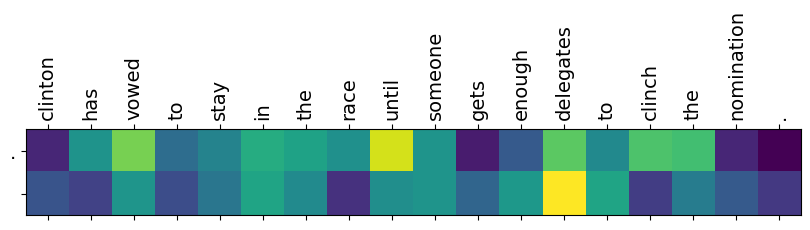

In [103]:
translate("clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination
Predicted translation: ['.', '']


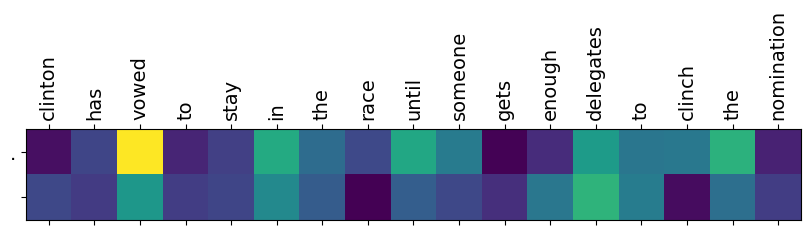

In [104]:
translate("clinton has vowed to stay in the race until someone gets enough delegates to clinch the nomination", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['.', '']


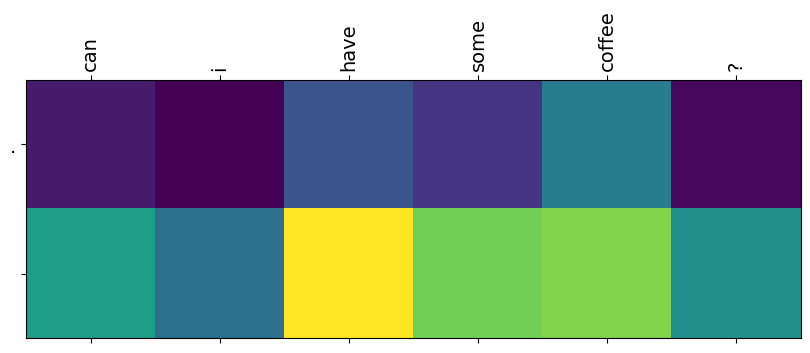

In [105]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: 
Predicted translation: ['purchase', 's', 'purchase', 's', 'purchase', 's', 'purchase', 's', 'hit', 'purchase', 's', 'tal', 'le', 'ft', 'viole', 'body', 'le', 'ft', 'viole', 'body', 'le', 'ft', 'viole', 'body', 'le', 'ft', 'viole', 'body', 'le', 'ft']


/tmp/ipython-input-304/3160434524.py:3: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.matshow(attention, cmap='viridis')


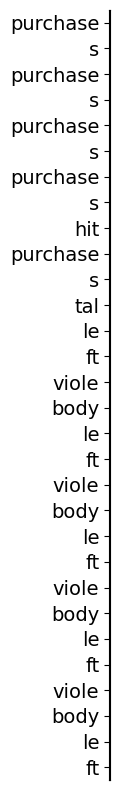

In [106]:
translate("나는 너를 사랑해", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: i love you .
Predicted translation: [',', 'le', 'ft', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',']


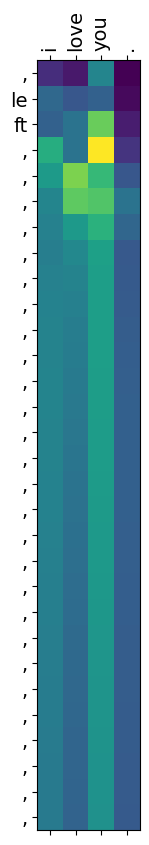

In [107]:
translate("I love you.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['.', '']


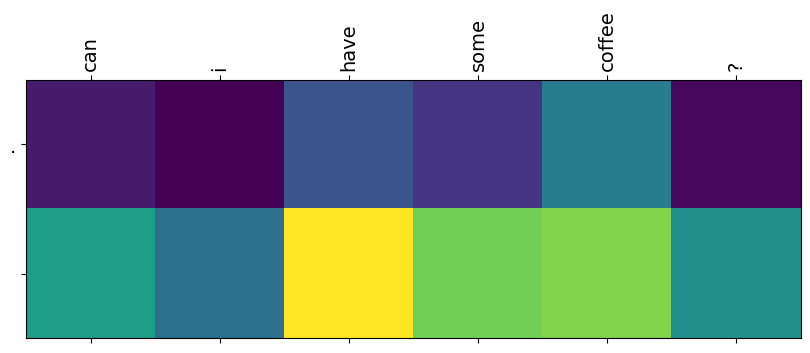

In [108]:
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: ?
Predicted translation: ['.', '']


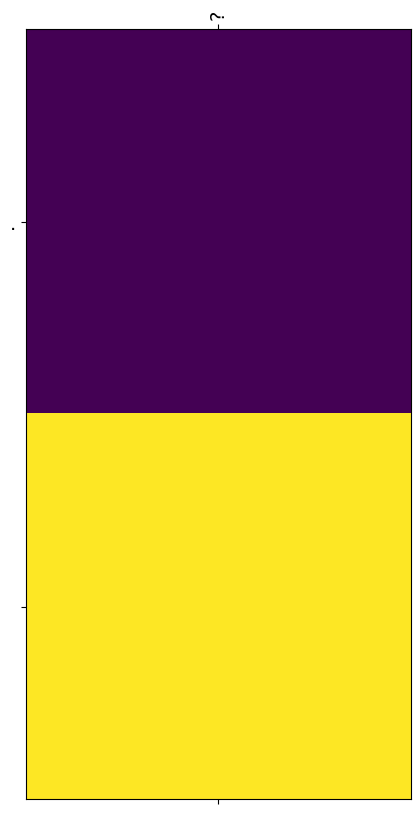

In [109]:
translate("나 너 사랑하니?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: a cup of coffee ?
Predicted translation: ['.', '']


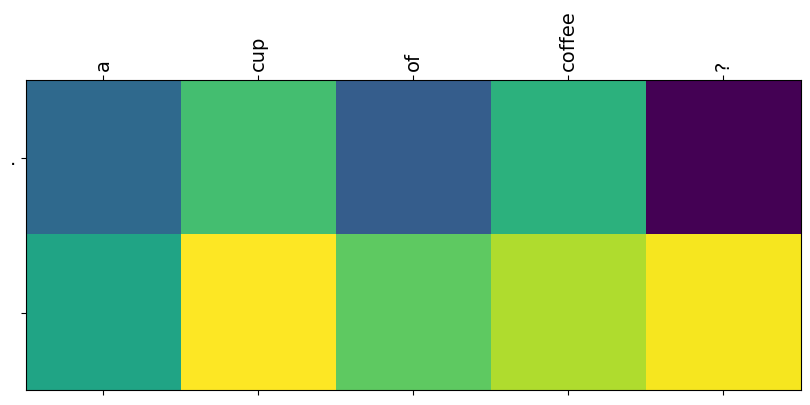

In [111]:
translate("a cup of coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

# 실패!!